# CNN for AED with Keras/TensorFlow

Date: November 11, 2018

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music
- Silence

## Preparing data set for CNN

In [29]:
DATASET_FOLDER = '../dataset/data_music'

%run dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.get_shape()
class_labels = ds.get_class_labels()

[[0, 2560], [2560, 5120], [5120, 7680]]


### CNN model

In [22]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
__________

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

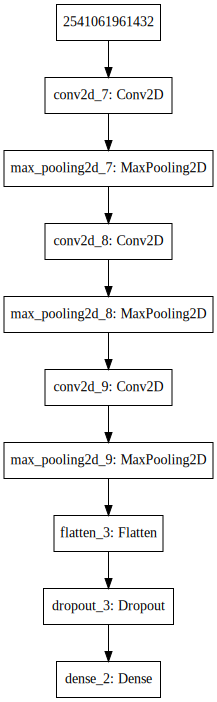

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [25]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 1206 samples, validate on 594 samples
Epoch 1/30
1206/1206 [==============================] - 7s 6ms/step - loss: 1.6872 - acc: 0.2670 - val_loss: 1.4121 - val_acc: 0.5421
Epoch 2/30
1206/1206 [==============================] - 6s 5ms/step - loss: 1.2532 - acc: 0.5473 - val_loss: 0.9051 - val_acc: 0.7391
Epoch 3/30
1206/1206 [==============================] - 7s 5ms/step - loss: 0.9259 - acc: 0.6476 - val_loss: 0.6372 - val_acc: 0.7929
Epoch 4/30
1206/1206 [==============================] - 6s 5ms/step - loss: 0.7670 - acc: 0.7222 - val_loss: 0.5295 - val_acc: 0.8199
Epoch 5/30
1206/1206 [==============================] - 7s 5ms/step - loss: 0.6441 - acc: 0.7595 - val_loss: 0.4986 - val_acc: 0.8367
Epoch 6/30
1206/1206 [==============================] - 6s 5ms/step - loss: 0.5939 - acc: 0.7828 - val_loss: 0.4400 - val_acc: 0.8182
Epoch 7/30
1206/1206 [==============================] - 6s 5ms/step - loss: 0.5106 - acc: 0.8018 - val_loss: 0.3909 - val_acc: 0.8552
Epoch 8/30
1206

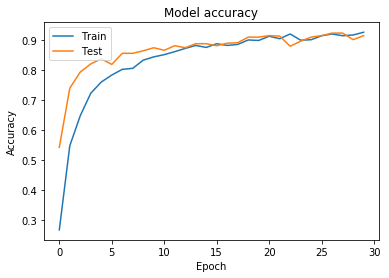

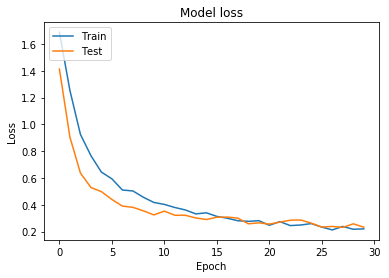

In [28]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [66]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [67]:
del model
model = models.load_model(filename)

## Confirmation

In [68]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(1206, 64, 40, 1)

In [69]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [51]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [52]:
class_labels

['blues_harp',
 'classical_guitar',
 'framenco_guitar',
 'piano',
 'silence',
 'tin_whistle']

In [53]:
(activations[-1][:10]*100).astype(int)

array([[ 1,  3,  0, 94,  0,  0],
       [ 0, 46,  0, 53,  0,  0],
       [ 0, 69, 28,  0,  0,  0],
       [99,  0,  0,  0,  0,  0],
       [ 0,  0, 99,  0,  0,  0],
       [ 0,  0,  0,  0, 99,  0],
       [ 0, 44,  1, 51,  3,  0],
       [ 0,  0,  0,  0,  0, 99],
       [ 0,  0,  0, 99,  0,  0],
       [ 7,  1,  7, 83,  0,  0]])

In [54]:
test_labels[:10].astype(int)

array([[0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [55]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'classical_guitar'

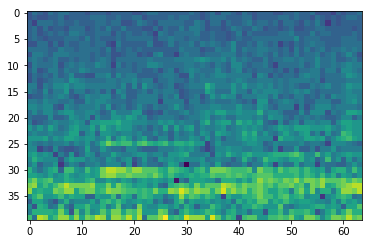

In [56]:
image_number = 25

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

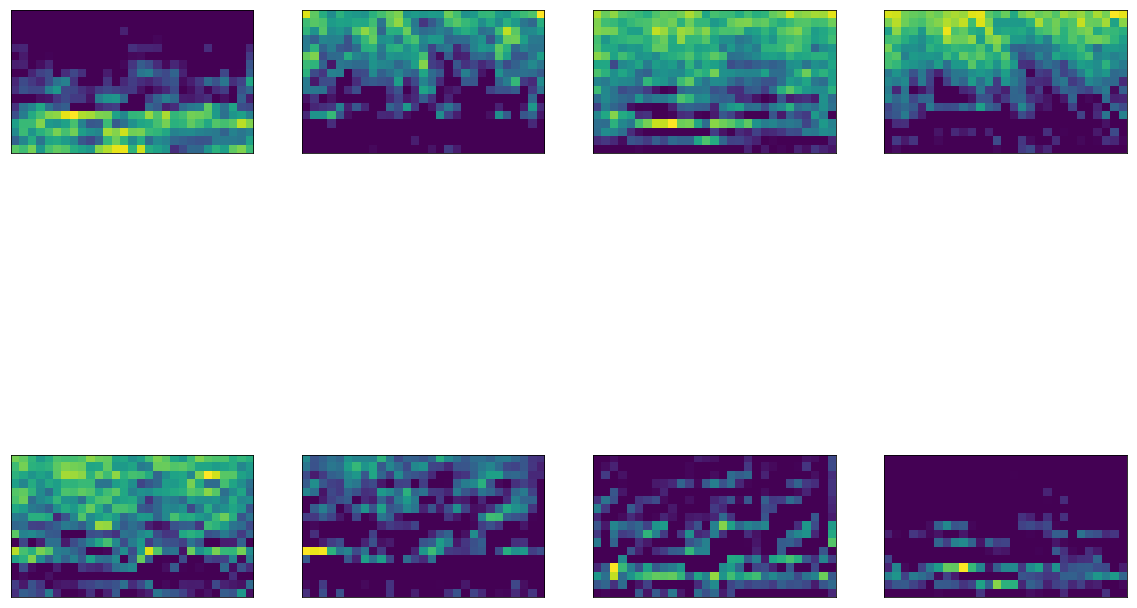

In [57]:
plot_layer(activations, image_number, 2)

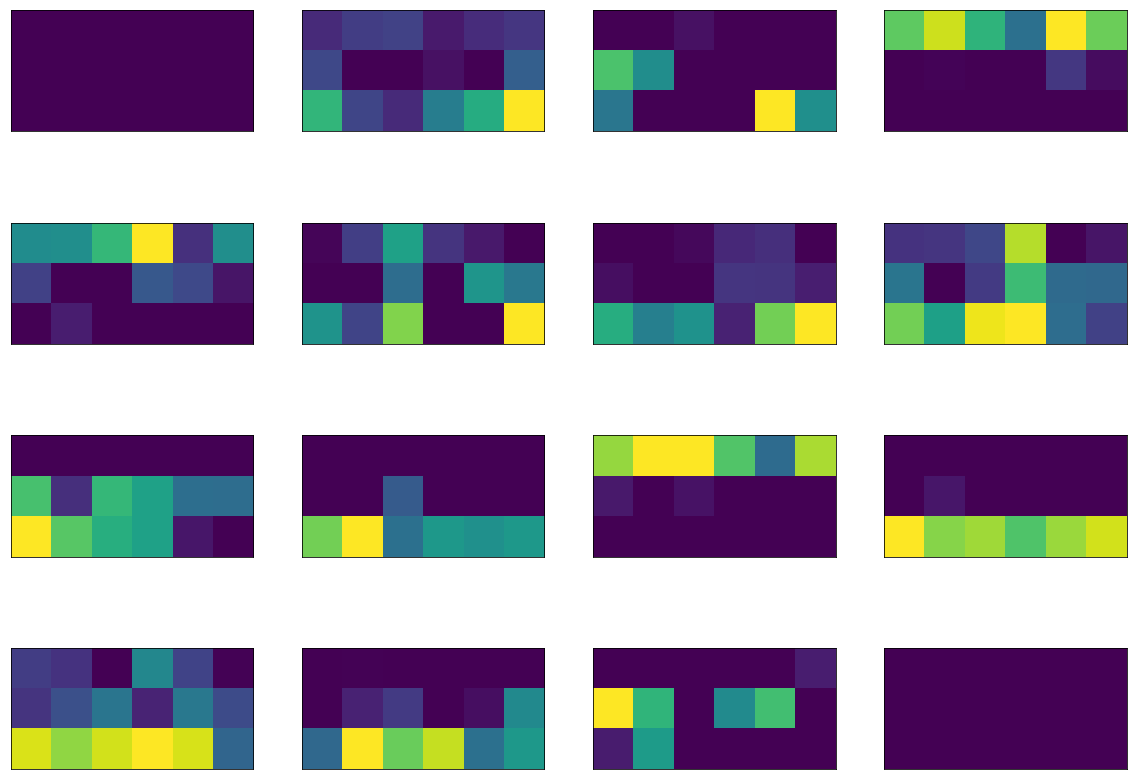

In [58]:
plot_layer(activations, image_number, 5)